### Imports


In [99]:
import pandas as pd
from db import Eleicao, Estado, Municipio, Zona, Secao, Log, MunicipioZona
import matplotlib.pyplot as plt
from datetime import datetime as dt
import ipywidgets as widgets
import seaborn as sns
from ipywidgets import interact, interact_manual
from IPython.display import display, clear_output
from bokeh.plotting import figure, show, output_notebook






In [100]:
# ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]

### Pegar Dados do 1º Turno

#### Informações da Seção

In [101]:
# Pegar Entradas do dia 02/10 
query = Log.select().where((Log.secao == 1) & (Log.datetime.day == 2) & (Log.datetime.month == 10) )


df = pd.DataFrame(list(query.dicts()))

# print(df.head)
# print(df.describe)

# Quantidade de Votos Computados
votos = df[df.descricao == 'O voto do eleitor foi computado']
print('Votos Computados: ', votos.shape[0])



Votos Computados:  240


#### Horário de Inicio e Fim das Atividades

In [102]:
comeco = df.iloc[0]
fim = df.iloc[-1]

print('As atividades começaram  às: ', comeco['datetime'].time())
print('As atividades terminaram às: ', fim['datetime'].time())


As atividades começaram  às:  07:05:30
As atividades terminaram às:  17:05:02


#### Primeiro Voto e Último Voto Computados

In [103]:
primeiro = votos.iloc[0]
ultimo = votos.iloc[-1]

print('O primeiro voto foi concluido às: ', primeiro['datetime'].time())
print('O último voto foi concluido às: ', ultimo['datetime'].time())

O primeiro voto foi concluido às:  08:06:19
O último voto foi concluido às:  16:46:42


#### Separandos os Logs por Hora

In [104]:
#horas
horas = pd.to_datetime(df.datetime).dt.hour.unique()

#resultados
result = pd.DataFrame(data=horas, columns=['Horas'])


# Dividir por hora
logs_por_hora = [g.reset_index(drop=True) for i,g in df.groupby(pd.to_datetime(df.datetime).dt.hour)]







#### Quantos votos por hora / Horários de Pico

In [105]:
cont = 0
votos = []

for dy in logs_por_hora:
    hora = horas[cont]
    voto = dy[dy.descricao == 'O voto do eleitor foi computado'].shape[0]
    votos.append(voto)
    cont += 1

result['Votos'] = votos
print(result.to_string())

    Horas  Votos
0       7      0
1       8     25
2       9     23
3      10     31
4      11     15
5      12     28
6      13     31
7      14     30
8      15     31
9      16     26
10     17      0


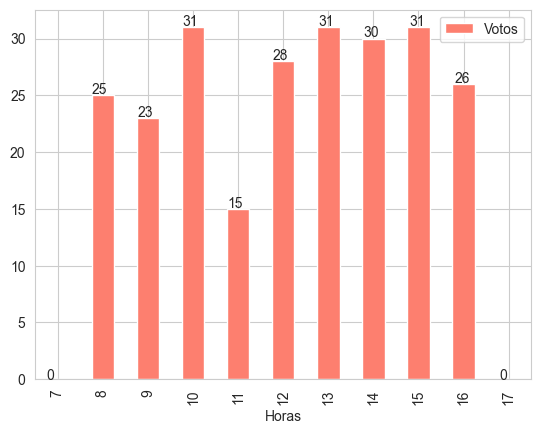

In [106]:
ax = result.plot(kind='bar', x = 'Horas', y='Votos', color='#fd7f6f')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


#### Tempo Médio de Votação

In [107]:
def format(tdelta):
    horas, rem =  divmod(tdelta.seconds, 3600)
    minutos, segundos = divmod(rem, 60)
    time = '{:02d}:{:02d}:{:02d}'.format(horas,minutos, segundos)
    return time
   

comeco = df.reset_index().index[df.descricao == 'Título digitado pelo mesário'].tolist()
fim = df.reset_index().index[df.descricao == 'O voto do eleitor foi computado'].tolist()
comeco.reverse()
fim.reverse()

xs = []
temp = []
for y in fim:
    for x in comeco:
        if(x < y):
            xs.append(x)
            temp.append((x,y))
            break

temp.reverse()
comeco.reverse()
fim.reverse()
xs.reverse()
temp2 = [x for x in comeco if x not in xs]


tempos = []
eleitores = [df.iloc[temp[x][0]:temp[x][1]] for x in range(0, len(temp)) ]
for eleitor in eleitores:
    inicio = eleitor.iloc[0]['datetime']
    fim = eleitor.iloc[-1]['datetime']
    diff = (fim - inicio)
    tempos.append(diff)
    # tempos.append(pd.to_datetime().dt.time)

temp_votacao  = pd.DataFrame(tempos, columns=['Tempo em Votação'])

print('Média de Tempo Para Votar: ', format(temp_votacao['Tempo em Votação'].mean()))





Média de Tempo Para Votar:  00:01:33


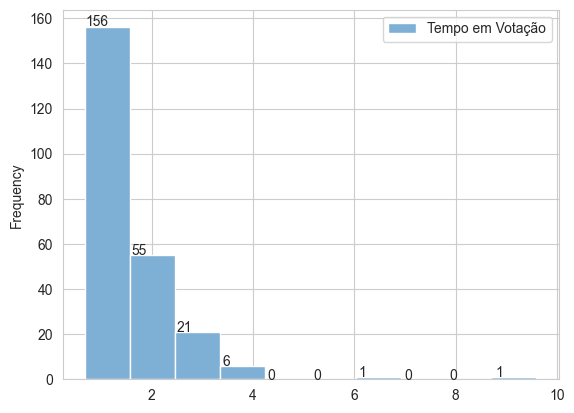

In [108]:
temp3 = temp_votacao.astype('timedelta64[s]') / 60
ax2 = temp3.plot.hist(color='#7eb0d5')
for p in ax2.patches:
    ax2.annotate(str(int(p.get_height())), (p.get_x() * 1.01, p.get_height() * 1.005))

(0.0, 5.0, 0.0, 160.0)

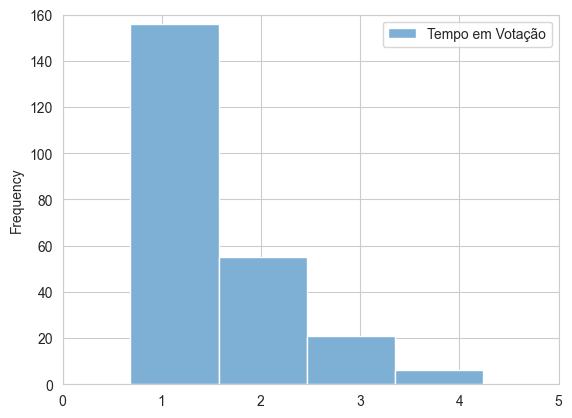

In [109]:
ax3 = temp_votacao.astype('timedelta64[s]') / 60
ax3.plot.hist(color='#7eb0d5').axis([0,5,0,160])


#### Tempo Médio dos Eleitores na Urna

In [110]:
comeco = df.reset_index().index[df.descricao == 'Eleitor foi habilitado'].tolist()
fim = df.reset_index().index[df.descricao == 'O voto do eleitor foi computado'].tolist()

tempos = []
eleitores = [df.iloc[comeco[x]:fim[x]] for x in range(0, len(comeco)) ]
for eleitor in eleitores:
    inicio = eleitor.iloc[0]['datetime']
    fim = eleitor.iloc[-1]['datetime']
    diff = (fim - inicio)
    tempos.append(diff)
    

temp_urna  = pd.DataFrame(tempos, columns=['Tempo na Urna'])

print('Média de Tempo Na Urna: ', format(temp_urna['Tempo na Urna'].mean()))

Média de Tempo Na Urna:  00:01:10


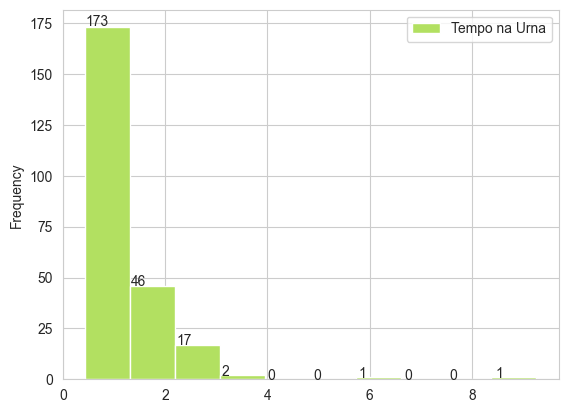

In [111]:
temp = temp_urna.astype('timedelta64[s]') / 60
ax4 = temp.plot.hist(color='#b2e061')
for p in ax4.patches:
    ax4.annotate(str(int(p.get_height())), (p.get_x() * 1.01, p.get_height() * 1.005))

(0.0, 5.0, 0.0, 180.0)

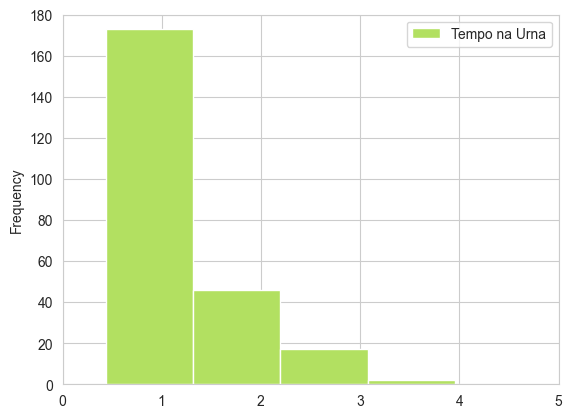

In [112]:
ax5 = temp_urna.astype('timedelta64[s]') / 60
ax5.plot.hist(color='#b2e061').axis([0,5,0,180])


#### Dificuldade na Votação


In [113]:
comeco = df.reset_index().index[df.descricao == 'Eleitor foi habilitado'].tolist()
fim = df.reset_index().index[df.descricao == 'O voto do eleitor foi computado'].tolist()

erros = []
eleitores = [df.iloc[comeco[x]:fim[x]] for x in range(0, len(comeco)) ]
for eleitor in eleitores:
    erros_durante_votacao = eleitor[eleitor.descricao == 'Tecla indevida pressionada'].shape[0]
    erros.append(erros_durante_votacao)

votacao = pd.DataFrame(erros, columns=['Erros na Votação'])
print(votacao.describe())


       Erros na Votação
count        240.000000
mean           1.708333
std            3.116687
min            0.000000
25%            0.000000
50%            0.000000
75%            2.000000
max           15.000000


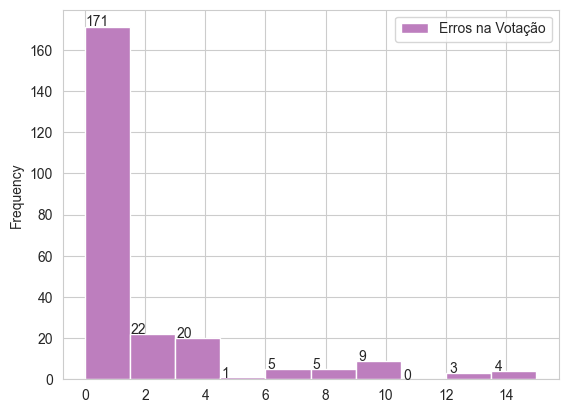

In [114]:
ax7 = votacao.plot.hist(color='#bd7ebe')
for p in ax7.patches:
    ax7.annotate(str(int(p.get_height())), (p.get_x() * 1.01, p.get_height() * 1.005))

#### Dificuldade no Reconhecimento da Digital

In [115]:
comeco = df.reset_index().index[df.descricao == 'Título digitado pelo mesário'].tolist()
fim = df.reset_index().index[df.descricao == 'O voto do eleitor foi computado'].tolist()
comeco.reverse()
fim.reverse()

xs = []
temp = []
for y in fim:
    for x in comeco:
        if(x < y):
            xs.append(x)
            temp.append((x,y))
            break

temp.reverse()
comeco.reverse()
fim.reverse()
xs.reverse()
temp2 = [x for x in comeco if x not in xs]


erros_digitais = []
eleitores = [df.iloc[temp[x][0]:temp[x][1]] for x in range(0, len(temp)) ]
for eleitor in eleitores:
    erro_digital = eleitor[eleitor['descricao'].str.contains('Digital capturada não corresponde a digital do eleitor')].shape[0]
    erros_digitais.append(erro_digital)
    # tempos.append(pd.to_datetime().dt.time)

digital  = pd.DataFrame(erros_digitais, columns=['Erros na Digital'])

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 4, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 4, 3, 0, 4, 4, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 4, 0, 2, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 1, 0, 0, 4, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 3, 0, 1, 1, 0, 1, 2, 0, 0, 0, 0, 4, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 0, 1, 4, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 3, 0, 0, 1, 0, 2, 2]
       Erros na Digital
count        240.000000
mean           0.625000
std            1.171935
min            0.000000
25%            0.000000
50%            0.000000
75%            1.000000
max            4.000000


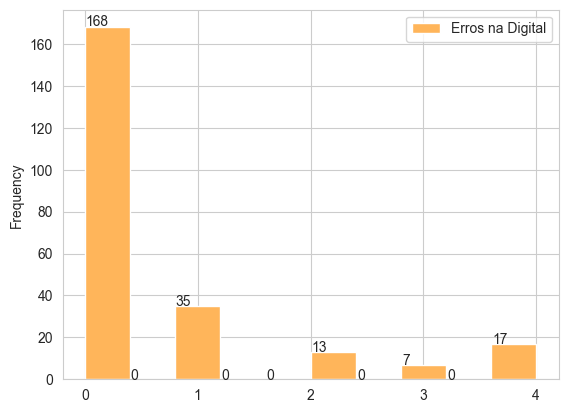

In [116]:
ax6 = digital.plot.hist(color = '#ffb55a', )
ax6.locator_params(axis='x', integer=True)
for p in ax6.patches:
    ax6.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

### Corelações entre os Dados


### Dificuldade no Reconhecimento da Digital X Erros Durante a Votação

<AxesSubplot: xlabel='Erros na Digital', ylabel='Erros na Votação'>

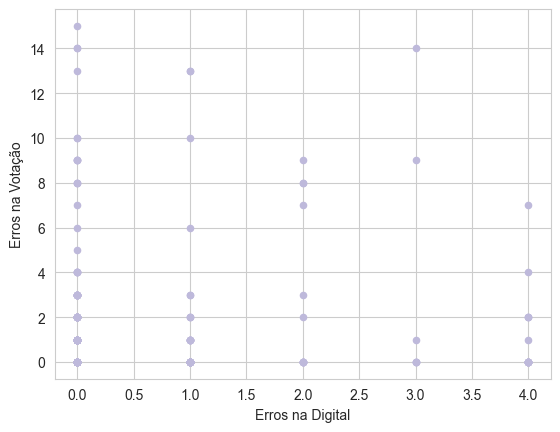

In [117]:
dig_x_vot = digital.join(votacao)

dig_x_vot.plot.scatter('Erros na Digital', 'Erros na Votação', color='#beb9db')

### Dificuldade no Reconhecimento da Digital X Tempo Gasto para Votar

<AxesSubplot: xlabel='Erros na Digital', ylabel='Tempo em Votação'>

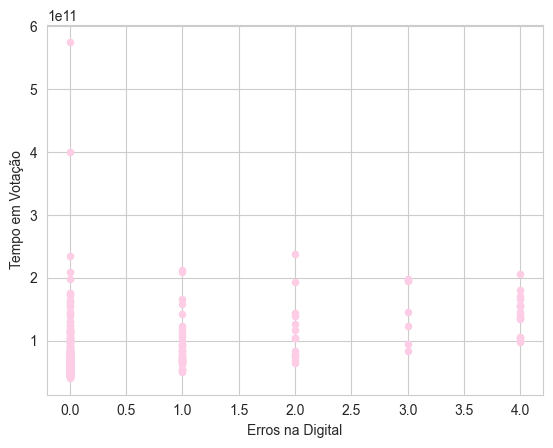

In [118]:
dig_x_tempv = digital.join(temp_votacao)

dig_x_tempv.plot.scatter('Erros na Digital', 'Tempo em Votação', color='#fdcce5')

### Erros Durante a Votação X  Tempo Gasto na Urna

<AxesSubplot: xlabel='Erros na Votação', ylabel='Tempo na Urna'>

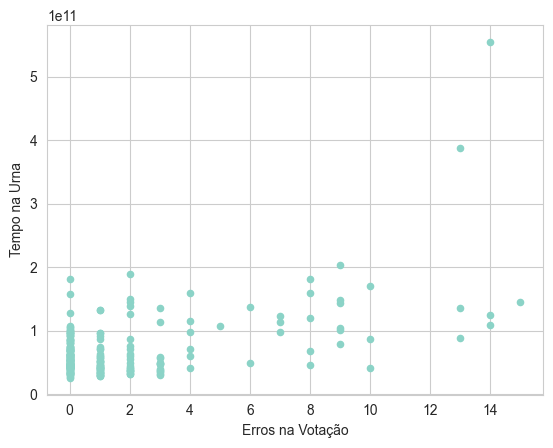

In [119]:
err_x_tempu = votacao.join(temp_urna)

err_x_tempu.plot.scatter('Erros na Votação', 'Tempo na Urna', color='#8bd3c7')

### Erros Durante a Votação X  Tempo Gasto para Votar

<AxesSubplot: xlabel='Erros na Votação', ylabel='Tempo em Votação'>

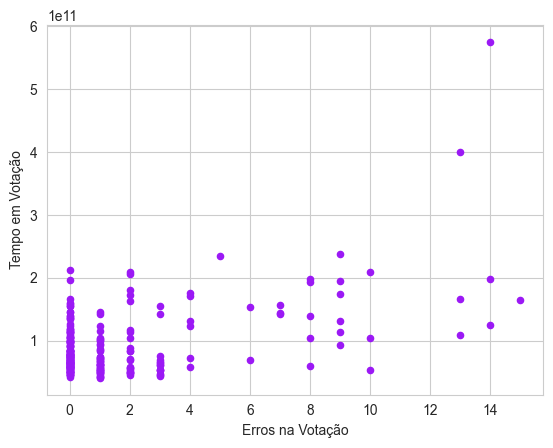

In [120]:
err_x_tempv = votacao.join(temp_votacao)

err_x_tempv.plot.scatter('Erros na Votação', 'Tempo em Votação', color='#9b19f5')

### DashBoard Interativo

In [121]:
database = temp_votacao.join(temp_urna).join(digital).join(votacao)
print(database.head())

  Tempo em Votação   Tempo na Urna  Erros na Digital  Erros na Votação
0  0 days 00:01:24 0 days 00:00:59                 0                 0
1  0 days 00:01:21 0 days 00:01:08                 0                 0
2  0 days 00:01:45 0 days 00:01:27                 0                 1
3  0 days 00:00:56 0 days 00:00:39                 0                 1
4  0 days 00:02:38 0 days 00:01:04                 1                 0


In [122]:

lista = database['Erros na Votação'].unique().tolist()
lista.sort()
@interact
def show_quantidade_erros(column=['Erros na Votação'], x = lista):
    return database.loc[database[column]  == x]


interactive(children=(Dropdown(description='column', options=('Erros na Votação',), value='Erros na Votação'),…

In [123]:
## DashBoard deve primeiro escolher o Turno, estado, Municipio, Zona, Secao 

In [124]:
query = Secao.select().where((Log.secao == 1) & (Log.datetime.day == 2) & (Log.datetime.month == 10) )


df = pd.DataFrame(list(query.dicts()))

In [125]:
query = Estado.select().where(Estado.eleicao==1)
a = list(query.dicts())


def get_list_estado(estado):
    return (estado['nome'], estado['id'])

lista = map(get_list_estado, a)
print(*lista, sep = ", ")



('Paraíba', 1)
